#### ***Importing the libraries***

In [2]:
import pandas as pd
import numpy as np 
import pymongo
import seaborn as sns
import matplotlib.pyplot as plt

#### ***Connection to MongoDB***

In [3]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["yelp"]

#### ***Queries***

##### ***Query 1***

A polarizing business is a one with high variance in star ratings. Find the most polarizing businesses in the category of restaurants; then, determine if user voting patterns (useful, funny, cool) correlate with the variance.

In [ ]:
query_results = db["reviews"].aggregate([{ 
                                            "$lookup" : { 
                                                "from" : "businesses", 
                                                "let" : { 
                                                    "business_id" : "$business_id" 
                                                },
                                                "pipeline" : [{
                                                                 "$match" : { 
                                                                    "$expr" : { 
                                                                        "$eq" : ["$business_id", "$$business_id"] 
                                                                    },
                                                                    "categories" : {
                                                                        "$regex": ".*Restaurants.*", "$options": "i"
                                                                    }
                                                                 }   
                                                             }],
                                                "as" : "business" 
                                            }
                                        },                            
                                        {
                                            "$unwind" : "$business"
                                        },                                        
                                        { 
                                            "$group" :  { 
                                                "_id" : "$business_id", 
                                                "business_name" : {
                                                    "$first": "$business.name"
                                                },
                                                "avgStars" : {
                                                    "$avg": "$stars"
                                                },
                                                "starVariance" : {
                                                    "$stdDevPop": "$stars"
                                                },
                                                "totalUsefulVotes" : {
                                                    "$sum": "$useful"
                                                },
                                                "totalFunnyVotes" : {
                                                    "$sum": "$funny"
                                                },
                                                "totalCoolVotes" : {
                                                    "$sum": "$cool"
                                                } 
                                            }
                                        },
                                        {
                                            "$match": {
                                                "starVariance": {
                                                    "$gt": 1.5
                                                }
                                            }
                                        },                                        
                                        { 
                                            "$project": { 
                                                "_id": 0, 
                                                "business_id": "$_id", 
                                                "business_name": 1, 
                                                "starVariance": 1, 
                                                "totalUsefulVotes": 1, 
                                                "totalFunnyVotes": 1, 
                                                "totalCoolVotes": 1 
                                            }
                                        }])

#Store the result in a DataFrame
df = pd.DataFrame(query_results)

In [ ]:
#Correlation analysis
correlation_matrix = df[["starVariance", "totalUsefulVotes", "totalFunnyVotes", "totalCoolVotes"]].corr()

#Rename the columns

print("Correlation Matrix:")
print(correlation_matrix)

#Visualization of "correltion matrix"
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Star Variance and Voting Patterns")
plt.show()

##### ***Query 2***

For businesses that operate in different locations (we assume that these are the ones for which there are two objects in ```businesses``` collection with same ```name```, but different ```city```), determine which city performs the best in terms of average star ratings and review frequency. Then,explore whether this correlates with local competition.

In [ ]:
query_results = db["businesses"].aggregate([{
                                                "$group" : {
                                                    "_id": "$name",
                                                    "locations" : { 
                                                        "$addToSet" : {
                                                            "city": "$city", 
                                                            "business_id": "$business_id" 
                                                        } 
                                                    },
                                                    "count" : {
                                                        "$sum" : 1 
                                                    }
                                                }
                                            },
                                            { 
                                                "$match" : { 
                                                    "count" : { 
                                                        "$gte" : 2 #Businesses having at least two different locations
                                                    } 
                                                } 
                                            },
                                            {
                                                "$unwind" : "$locations"
                                            },
                                            {
                                                "$lookup" : {
                                                    "from" : "reviews",
                                                    "localField" : "locations.business_id",
                                                    "foreignField" : "business_id",
                                                    "as": "reviews"
                                                }
                                            },
                                            {
                                                "$unwind" : "$reviews" 
                                            },
                                            {
                                                "$group" : {
                                                    "_id" : {
                                                        "name" : "$_id", 
                                                        "city" : "$locations.city" 
                                                    },
                                                    "avgStars" : {
                                                        "$avg": "$reviews.stars"
                                                    },
                                                    "reviewCount" : {
                                                        "$sum" : 1
                                                    },
                                                    "businessCount" : {
                                                        "$addToSet" : "$reviews.business_id"
                                                    }
                                                }
                                            },
                                            {
                                                "$addFields" : {
                                                    "localCompetition" : {
                                                        "$expr" : {
                                                            "$subtract" : [{"$size": "$businessCount"}, 1]}
                                                    }
                                                }
                                            },
                                            {
                                                "$project" : {
                                                    "_id": 0,
                                                    "business_name": "$_id.name",
                                                    "city": "$_id.city",
                                                    "avgStars": 1,
                                                    "reviewCount": 1,
                                                    "localCompetition": 1
                                                }
                                            }])

#Store the result in a DataFrame
df = pd.DataFrame(query_results)

Correlation Matrix:
                  avgStars  reviewCount  localCompetition
avgStars          1.000000    -0.028139         -0.017127
reviewCount      -0.028139     1.000000          0.834322
localCompetition -0.017127     0.834322          1.000000


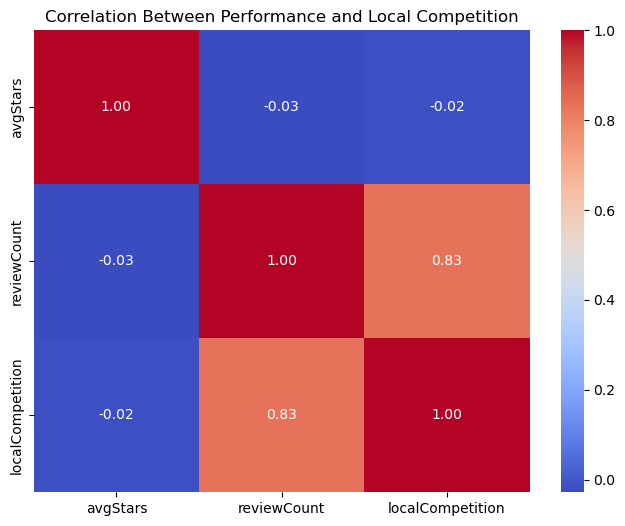

In [10]:
#Correlation analysis
correlation_matrix = df[["avgStars", "reviewCount", "localCompetition"]].corr()

#TODO: rename the columns

print("Correlation Matrix:")
print(correlation_matrix)

#Visualization of "correlation_matrix"
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation Between Performance and Local Competition")
plt.show()